<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-metadata-predictions" data-toc-modified-id="Evaluation-of-metadata-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation of metadata predictions</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Load-necessary-packages" data-toc-modified-id="Load-necessary-packages-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load necessary packages</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-embedding-model" data-toc-modified-id="Load-embedding-model-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Load embedding model</a></span></li><li><span><a href="#Create-dataframe" data-toc-modified-id="Create-dataframe-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Create dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Prediction-performance" data-toc-modified-id="Prediction-performance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prediction performance</a></span><ul class="toc-item"><li><span><a href="#Covert-to-lower-case-for-better-comparison" data-toc-modified-id="Covert-to-lower-case-for-better-comparison-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Covert to lower case for better comparison</a></span></li><li><span><a href="#Overall-prediction-stats" data-toc-modified-id="Overall-prediction-stats-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Overall prediction stats</a></span></li><li><span><a href="#Exact-matches" data-toc-modified-id="Exact-matches-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Exact matches</a></span></li><li><span><a href="#Contained-within" data-toc-modified-id="Contained-within-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Contained within</a></span></li><li><span><a href="#Cosine-similarity" data-toc-modified-id="Cosine-similarity-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Cosine similarity</a></span></li><li><span><a href="#If-either-cosine-or-contain" data-toc-modified-id="If-either-cosine-or-contain-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>If either cosine or contain</a></span><ul class="toc-item"><li><span><a href="#BLEU-scoring" data-toc-modified-id="BLEU-scoring-1.2.6.1"><span class="toc-item-num">1.2.6.1&nbsp;&nbsp;</span>BLEU scoring</a></span></li><li><span><a href="#Levenshtein-distance" data-toc-modified-id="Levenshtein-distance-1.2.6.2"><span class="toc-item-num">1.2.6.2&nbsp;&nbsp;</span>Levenshtein distance</a></span></li></ul></li></ul></li><li><span><a href="#Examples-of-misses?" data-toc-modified-id="Examples-of-misses?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Examples of misses?</a></span></li></ul></li></ul></div>

# Evaluation of metadata predictions
Adam Klie<br>
12/08/2019<br>
Script to evaluate predictions

## Set-up

### Load necessary packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Load data

#### Load embedding model

In [2]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


#### Create dataframe

In [3]:
model_iter = '11_class'

In [4]:
grouping = pd.read_csv('../results/embedding/{model}/entity_merging.csv'.format(model=model_iter), index_col=0)

In [5]:
groups = grouping[grouping["I"] == 0]["GroupName"].values

In [6]:
import warnings
warnings.filterwarnings('ignore')
validation_data_count = {}
merged = pd.DataFrame()
total_count = 0
for group in groups:
    group_dir = group.replace(' ', '_')
    group_dir = group_dir.replace('/', '_')
    #if group == "Platform":
    #    continue
    predicted_df = pd.read_pickle(
    '../results/prediction/{mymodel}/{myclass}_prediction.pickle'.format(mymodel = model_iter, 
                                                                          myclass = group_dir))
    class_validation = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_values.pickle'.format(mymodel = model_iter, 
                                                                                myclass = group_dir))
    validation_data = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_set.pickle'.format(mymodel = model_iter, 
                                                                             myclass = group_dir))
    class_df = predicted_df[predicted_df['predicted'] == group]
    print(group, ":", validation_data.shape[0], ",", class_df.shape[0])
    validation_data_count[group] = validation_data.shape[0]
    tmp_df = class_validation.loc[class_df['srs'].values]
    tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]
    class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values
    merged = pd.concat([merged, class_df], axis=0)
    total_count = total_count + validation_data.shape[0]

Species : 1000 , 855
Strain : 1000 , 295
Cell type : 702 , 144
Genotype : 595 , 130
Condition/Disease : 122 , 23
Tissue : 1000 , 237
Sex : 190 , 4
Age : 1000 , 224
Data type : 78 , 12
Platform : 275 , 30
Protocol : 18 , 0


## Prediction performance

### Covert to lower case for better comparison

In [45]:
merged["token"] = merged["token"].str.lower()
merged["actual"] = merged["actual"].str.lower()

### Overall prediction stats

In [46]:
predicted_count = merged.shape[0]
print(('%d/%d (%.2f%%) predicted' % 
       (predicted_count, total_count, predicted_count/total_count*100)))

1954/5980 (32.68%) predicted


In [47]:
merged["predicted"].value_counts()

Species              855
Strain               295
Tissue               237
Age                  224
Cell type            144
Genotype             130
Platform              30
Condition/Disease     23
Data type             12
Sex                    4
Name: predicted, dtype: int64

In [48]:
# missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
# missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
# if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
#     missing_df['TITLE'] = missing.values

In [49]:
# missing_df.to_csv(
#     '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

### Exact matches

In [50]:
merged["exact_match"] = merged['token'] == merged['actual']

In [51]:
num_correct = merged["exact_match"].sum()
print(('%d/%d (%.2f%%) exact matches' % 
       (num_correct, predicted_count, num_correct/predicted_count*100)))

466/1954 (23.85%) exact matches


In [52]:
class_exact = merged.groupby(['predicted', 'exact_match']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='exact_match')
class_exact

0       
exact_match        False  True 
predicted                      
Age                186.0   38.0
Cell type          142.0    2.0
Condition/Disease   10.0   13.0
Data type           12.0    NaN
Genotype           108.0   22.0
Platform            30.0    NaN
Sex                  4.0    NaN
Species            528.0  327.0
Strain             273.0   22.0
Tissue             195.0   42.0

In [53]:
merged.groupby('exact_match').mean()["score"]

exact_match
False    0.404395
True     0.531036
Name: score, dtype: float32

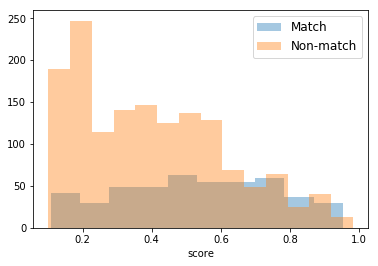

In [54]:
sns.distplot(merged[merged['exact_match'] == True]['score'], label='Match', kde=False)
sns.distplot(merged[merged['exact_match'] == False]['score'], label='Non-match', kde=False)
plt.legend(prop={'size': 12})

In [55]:
# exact_correct_df.to_csv(
#     '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
# exact_incorrect_df.to_csv(
#     '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

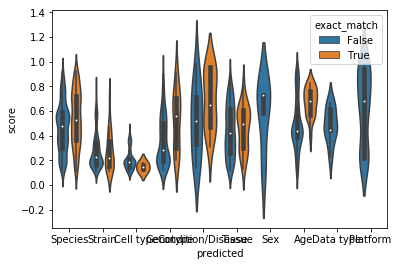

In [56]:
ax = sns.violinplot(x='predicted', y='score', data=merged, hue='exact_match')

### Contained within

In [57]:
def within(x):
    if (x["actual"] in x['token']) or (x['token'] in x["actual"]):
        return True
    else:
        return False

In [58]:
merged['within'] = merged.apply(within, axis=1)
count = merged['within'].sum()

In [59]:
print(('%d/%d (%.2f%%) of predicted contained in actual' % 
       (count, predicted_count, count/predicted_count*100)))

1330/1954 (68.07%) of predicted contained in actual


In [60]:
class_contain = merged.groupby(['predicted', 'within']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='within')
class_contain.columns = ["non-match", "match"]
class_contain["fraction_match"] = class_contain["match"]/class_contain.sum(axis=1)

In [61]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,160.0,64.0,0.285714
Cell type,90.0,54.0,0.375000
Condition/Disease,3.0,20.0,0.869565
Data type,12.0,NaN,NaN
Genotype,80.0,50.0,0.384615
Platform,21.0,9.0,0.300000
Sex,3.0,1.0,0.250000
Species,95.0,760.0,0.888889
Strain,54.0,241.0,0.816949


### Cosine similarity

In [62]:
predicted_docs = nlp.pipe(merged['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(merged['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [63]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [64]:
merged["cosine_similarity"] = similarities

(array([340.,  98.,  46.,  36.,  51.,  42.,  88., 121., 198., 934.]),
 array([-0.04997848,  0.0550194 ,  0.16001727,  0.26501514,  0.37001301,
         0.47501088,  0.58000875,  0.68500662,  0.7900045 ,  0.89500237,
         1.00000024]),
 <a list of 10 Patch objects>)

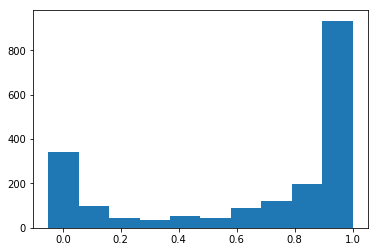

In [65]:
plt.hist(merged['cosine_similarity'])

In [92]:
sim_threshold = 0.70
merged["cosine_match"] = merged['cosine_similarity'].values > sim_threshold
num_sim = merged["cosine_match"].sum()

In [93]:
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

1245/1954 (63.72%) Predicted with cosine similarity greater than 0.7



In [94]:
class_cosine = merged.groupby(['predicted', 'cosine_match']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='cosine_match')
class_cosine.columns = ["non-match", "match"]
class_cosine["fraction_match"] = class_cosine["match"]/class_cosine.sum(axis=1)

In [95]:
class_cosine

,non-match,match,fraction_match
predicted,,,
Age,121.0,103.0,0.459821
Cell type,80.0,64.0,0.444444
Condition/Disease,2.0,21.0,0.913043
Data type,2.0,10.0,0.833333
Genotype,65.0,65.0,0.500000
Platform,19.0,11.0,0.366667
Sex,NaN,4.0,1.000000
Species,56.0,799.0,0.934503
Strain,269.0,26.0,0.088136


In [96]:
title_counts = pd.DataFrame(pd.Series(validation_data_count), columns=['titles'])

In [97]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,160.0,64.0,0.285714
Cell type,90.0,54.0,0.375000
Condition/Disease,3.0,20.0,0.869565
Data type,12.0,NaN,NaN
Genotype,80.0,50.0,0.384615
Platform,21.0,9.0,0.300000
Sex,3.0,1.0,0.250000
Species,95.0,760.0,0.888889
Strain,54.0,241.0,0.816949


### If either cosine or contain

In [104]:
merged["either"] = merged["within"] | merged["cosine_match"]

In [108]:
class_either = merged.groupby(['predicted', 'either']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='either')
class_either.columns = ["non-match", "match"]
class_either["either_match"] = class_either["match"]/class_either.sum(axis=1)

In [109]:
class_either

,non-match,match,either_match
predicted,,,
Age,118.0,106.0,0.473214
Cell type,76.0,68.0,0.472222
Condition/Disease,1.0,22.0,0.956522
Data type,2.0,10.0,0.833333
Genotype,49.0,81.0,0.623077
Platform,19.0,11.0,0.366667
Sex,NaN,4.0,1.000000
Species,44.0,811.0,0.948538
Strain,53.0,242.0,0.820339


In [119]:
table1 = class_cosine.merge(pd.DataFrame(merged["predicted"].value_counts()), left_index=True, right_index=True)
table1 = table1.merge(title_counts, left_index=True, right_index=True)
table1 = table1.merge(class_contain, left_index=True, right_index=True, suffixes=['_cosine', '_contain'])
table1 = table1.merge(class_either, left_index=True, right_index=True, suffixes=['_either', '_either'])

In [120]:
table1["fraction_predicted"] = table1['predicted']/table1['titles']

In [121]:
table1

,non-match_cosine,match_cosine,fraction_match_cosine,predicted,titles,non-match_contain,match_contain,fraction_match_contain,non-match,match,either_match,fraction_predicted
Age,121.0,103.0,0.459821,224,1000,160.0,64.0,0.285714,118.0,106.0,0.473214,0.224000
Cell type,80.0,64.0,0.444444,144,702,90.0,54.0,0.375000,76.0,68.0,0.472222,0.205128
Condition/Disease,2.0,21.0,0.913043,23,122,3.0,20.0,0.869565,1.0,22.0,0.956522,0.188525
Data type,2.0,10.0,0.833333,12,78,12.0,NaN,NaN,2.0,10.0,0.833333,0.153846
Genotype,65.0,65.0,0.500000,130,595,80.0,50.0,0.384615,49.0,81.0,0.623077,0.218487
Platform,19.0,11.0,0.366667,30,275,21.0,9.0,0.300000,19.0,11.0,0.366667,0.109091
Sex,NaN,4.0,1.000000,4,190,3.0,1.0,0.250000,NaN,4.0,1.000000,0.021053
Species,56.0,799.0,0.934503,855,1000,95.0,760.0,0.888889,44.0,811.0,0.948538,0.855000
Strain,269.0,26.0,0.088136,295,1000,54.0,241.0,0.816949,53.0,242.0,0.820339,0.295000
Tissue,95.0,142.0,0.599156,237,1000,106.0,131.0,0.552743,86.0,151.0,0.637131,0.237000


In [122]:
table1 = table1[['titles', 'predicted', 'fraction_predicted', 
        'match_cosine', 'fraction_match_cosine', 'match_contain', 'fraction_match_contain', 'match', 'either_match']]

In [123]:
table1['percent_correct'] = table1[["fraction_match_cosine", "fraction_match_contain"]].max(axis=1)

In [124]:
table1

,titles,predicted,fraction_predicted,match_cosine,fraction_match_cosine,match_contain,fraction_match_contain,match,either_match,percent_correct
Age,1000,224,0.224000,103.0,0.459821,64.0,0.285714,106.0,0.473214,0.459821
Cell type,702,144,0.205128,64.0,0.444444,54.0,0.375000,68.0,0.472222,0.444444
Condition/Disease,122,23,0.188525,21.0,0.913043,20.0,0.869565,22.0,0.956522,0.913043
Data type,78,12,0.153846,10.0,0.833333,NaN,NaN,10.0,0.833333,0.833333
Genotype,595,130,0.218487,65.0,0.500000,50.0,0.384615,81.0,0.623077,0.500000
Platform,275,30,0.109091,11.0,0.366667,9.0,0.300000,11.0,0.366667,0.366667
Sex,190,4,0.021053,4.0,1.000000,1.0,0.250000,4.0,1.000000,1.000000
Species,1000,855,0.855000,799.0,0.934503,760.0,0.888889,811.0,0.948538,0.934503
Strain,1000,295,0.295000,26.0,0.088136,241.0,0.816949,242.0,0.820339,0.816949
Tissue,1000,237,0.237000,142.0,0.599156,131.0,0.552743,151.0,0.637131,0.599156


In [125]:
table1.to_csv('../doc/tables/Table1.csv', index=True)

#### BLEU scoring

In [40]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [41]:
smoother = SmoothingFunction()
table1["BLUE1"] = table1.apply(bleu1, axis=1)
table1["BLUE4"] = table1.apply(bleu4, axis=1)

KeyError: ('actual', 'occurred at index Age')

#### Levenshtein distance

In [ ]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [ ]:
table1["levenshtein"] = table1.apply(levenshtein, axis=1)

## Examples of misses?

In [135]:
missed = merged[~merged["either"]]
missed_df = missed[["predicted", "orig_text","recovered_txt", "actual"]]

In [136]:
missed_df.to_csv('../doc/figures/Supplementary/Supp_Table3.csv')

In [134]:
missed.columns

Index(['srs', 'attribute', 'sentence_number', 'kthSrs', 'orig_text',
       'n-gram_length', 'word_start', 'word_end', 'token', 'starting_char_pos',
       'predicted', 'score', 'OverlapGroup', 'token_len', 'recovered_txt',
       'actual', 'exact_match', 'within', 'cosine_similarity', 'cosine_match',
       'either'],
      dtype='object')